# Plant Disease Detection - Deep Learning Project

## Initial Setup

In [1]:
# Imports
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import shutil
import random
import importlib
import pandas as pd
import albumentations as A
import numpy as np

from tqdm.auto import tqdm
from torch import nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from typing import Dict, List
from albumentations.pytorch import ToTensorV2

try:
    from torchinfo import summary
except:
    ! pip install torchinfo
    from torchinfo import summary


try:
    import helpers
except:
    print("[INFO] Couldn't find helpers modules fetching them from github.")
    !git clone https://github.com/othmane-mahfoud/plant-disease-detection.git
    !mv plant-disease-detection/helpers .
    !rm -rf plant-disease-detection
    import helpers

[INFO] Couldn't find helpers modules fetching them from github.
Cloning into 'plant-disease-detection'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 82 (delta 29), reused 78 (delta 25), pack-reused 0
Receiving objects: 100% (82/82), 11.10 MiB | 10.50 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
import helpers.setup
importlib.reload(helpers.setup)
from helpers.setup import set_device, set_seeds, set_pandas_options, reset_pandas_options

# Set the device
device = set_device()

# Set random seeds
set_seeds(seed=42, device=device)

# Pandas display setup to avoid truncation
set_pandas_options()
reset_pandas_options()

# Some running instructions
is_experiment = False

### Mount Google Drive for Colab

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not using collab")

Mounted at /content/drive


## Data Acquisition

In [4]:
import helpers.acquisition
importlib.reload(helpers.acquisition)
from helpers.acquisition import create_dataset

url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"
data_dir = "data"
zip_path = os.path.join(data_dir, "data_compressed.zip")
extracted_dir = "Plant_leave_diseases_dataset_without_augmentation"
splits = {
    'data_10_10_80': [0.1, 0.1, 0.8], #train 10% test 10% holdout 80%
    'data_20_10_70': [0.2, 0.1, 0.7],
    'data_30_10_60': [0.3, 0.1, 0.6],
    'data_70_20_10': [0.7, 0.2, 0.1]
}

create_dataset(url, zip_path, splits, data_dir, extracted_dir)

  0%|          | 0.00/868M [00:00<?, ?iB/s]

Dataset downloaded and saved to data/data_compressed.zip
Extracting dataset...
Dataset extracted to data
Dataset splits generated successfully!


## Data Exploration

In [5]:
import helpers.exploration
importlib.reload(helpers.exploration)
from helpers.exploration import traverse_dirs

data_dir_names = list(splits.keys())
classes_df = traverse_dirs(data_dir_names)
classes_df = classes_df.groupby(["dataset", "split_type", "class"]).sum()
classes_df

image_count
dataset       split_type class                                                     
data_10_10_80 holdout    Apple___Apple_scab                                     504
                         Apple___Black_rot                                      497
                         Apple___Cedar_apple_rust                               221
                         Apple___healthy                                       1317
                         Background_without_leaves                              915
...                                                                             ...
data_70_20_10 train      Tomato___Spider_mites Two-spotted_spider_mite         1173
                         Tomato___Target_Spot                                   982
                         Tomato___Tomato_Yellow_Leaf_Curl_Virus                3749
                         Tomato___Tomato_mosaic_virus                           261
                         Tomato___healthy                                      1113

[468 rows x 1 columns]

## Data Preparation and Augmentation

### Create Datasets and Dataloaders

In [6]:
import helpers.preparation
importlib.reload(helpers.preparation)
from helpers.preparation import create_dataloaders, display_img_grid, display_img_sample

import albumentations as A
from albumentations.pytorch import ToTensorV2

test_transform = A.Compose([
    A.Resize(264, 264),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader_10_10_80_aug, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train",
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_10_10_80_cut, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train",
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_10_10_80, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train",
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_20_10_70_aug, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train",
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_20_10_70_cut, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train",
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_20_10_70, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train",
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_30_10_60_aug, test_dataloader_30_10_60 = create_dataloaders("data_30_10_60/train",
                                                                         "data_30_10_60/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_30_10_60_cut, test_dataloader_30_10_60 = create_dataloaders("data_30_10_60/train",
                                                                         "data_30_10_60/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_30_10_60, test_dataloader_30_10_60 = create_dataloaders("data_30_10_60/train",
                                                                         "data_30_10_60/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_70_20_10_aug, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train",
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_70_20_10_cut, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train",
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_70_20_10, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train",
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

len(train_dataloader_10_10_80_aug), len(train_dataloader_10_10_80), len(test_dataloader_10_10_80)

len(train_dataloader_20_10_70_aug), len(train_dataloader_20_10_70), len(test_dataloader_20_10_70)

len(train_dataloader_30_10_60_aug), len(train_dataloader_30_10_60), len(test_dataloader_30_10_60)

len(train_dataloader_70_20_10_aug), len(train_dataloader_70_20_10), len(test_dataloader_70_20_10)

(1213, 1213, 347)

### Display Sample Batches and Images

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


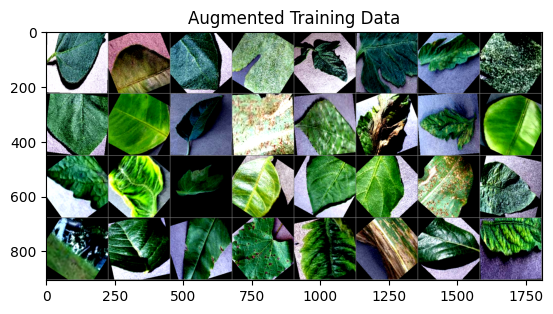

Soybean___healthy
Orange___Haunglongbing_(Citrus_greening)
Soybean___healthy
Squash___Powdery_mildew
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Bacterial_spot
Tomato___Leaf_Mold
Tomato___healthy
Soybean___healthy
Orange___Haunglongbing_(Citrus_greening)
Apple___healthy
Corn___Common_rust
Cherry___Powdery_mildew
Tomato___Late_blight
Tomato___Leaf_Mold
Orange___Haunglongbing_(Citrus_greening)
Tomato___Late_blight
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Late_blight
Orange___Haunglongbing_(Citrus_greening)
Pepper,_bell___healthy
Pepper,_bell___healthy
Corn___Common_rust
Tomato___Spider_mites Two-spotted_spider_mite
Background_without_leaves
Blueberry___healthy
Peach___Bacterial_spot
Grape___Black_rot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Corn___Cercospora_leaf_spot Gray_leaf_spot
Blueberry___healthy
Tomato___Tomato_mosaic_virus


In [7]:
display_img_grid(train_dataloader_10_10_80_aug, "Augmented Training Data")

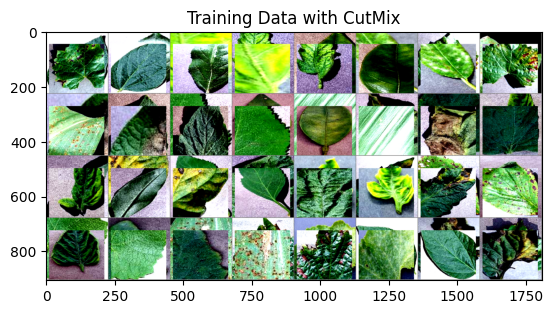

Grape___Black_rot
Soybean___healthy
Apple___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Orange___Haunglongbing_(Citrus_greening)
Cherry___Powdery_mildew
Grape___Esca_(Black_Measles)
Corn___Common_rust
Potato___Late_blight
Tomato___Spider_mites Two-spotted_spider_mite
Cherry___healthy
Orange___Haunglongbing_(Citrus_greening)
Corn___healthy
Potato___Late_blight
Tomato___Bacterial_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Peach___healthy
Tomato___Early_blight
Cherry___healthy
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Early_blight
Strawberry___Leaf_scorch
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Grape___healthy
Tomato___Bacterial_spot
Corn___Common_rust
Grape___Esca_(Black_Measles)
Squash___Powdery_mildew
Soybean___healthy
Tomato___Early_blight


In [8]:
display_img_grid(train_dataloader_10_10_80_cut, "Training Data with CutMix", is_cutmix=True)

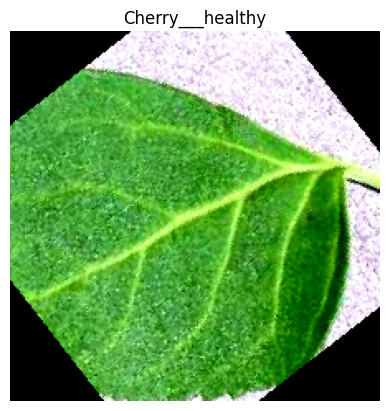

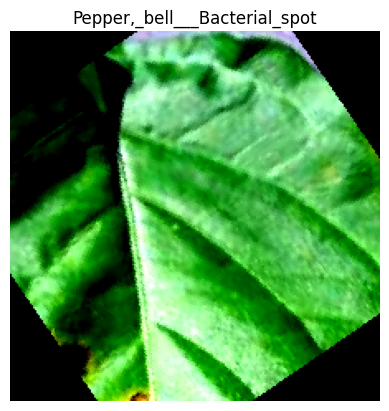

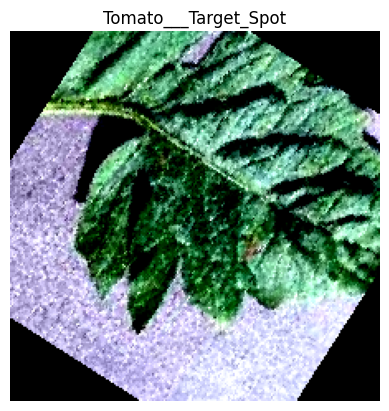

In [9]:
display_img_sample(train_dataloader_10_10_80_aug, "Sample Augmented Data with Labels", sample_size=3)

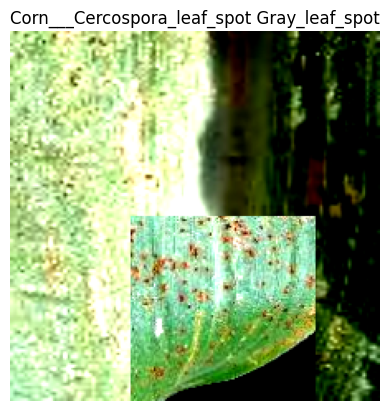

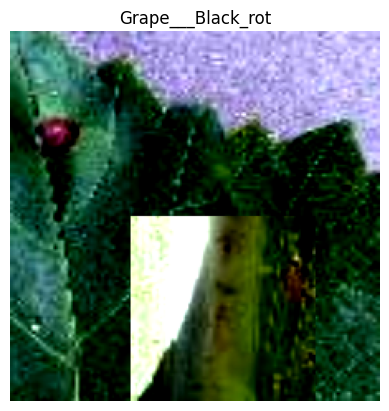

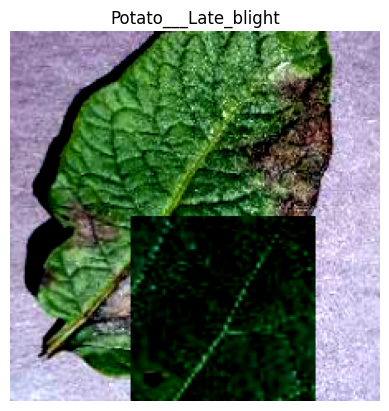

In [10]:
display_img_sample(train_dataloader_10_10_80_cut, "Sample Cutmix Data with Labels", is_cutmix=True, sample_size=3)

## Modeling

### Getting Pre-trained Models

In [11]:
import helpers.modeling
importlib.reload(helpers.modeling)
from helpers.modeling import create_effnetb0, create_vit, create_hybrid

# EfficientNetB0 - as the highest performing overall in Hassan et al. 99.56%
effnetb0_model = create_effnetb0(device, out_features=39)

# ViT - example of transformer based approach
vit_model = create_vit(device, out_features=39)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 90.4MB/s]


EffNetB0 model created successfully.


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 229MB/s]


ViT model created successfully.


In [12]:
summary(model=effnetb0_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 39]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [13]:
summary(model=vit_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 39]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### Create Base Model and Hybrid Model

---



In [14]:
import helpers.modeling
importlib.reload(helpers.modeling)
from helpers.modeling import create_effnetb0, create_vit, create_hybrid, create_base_model

hybrid_model = create_hybrid(device, out_features=39, dropout_proba=0.2)
input_tensor = torch.randn(1, 3, 224, 224)
output = hybrid_model(input_tensor)
print(output.shape)

Hybrid model created successfully.
torch.Size([1, 39])


In [15]:
dataiter = iter(train_dataloader_10_10_80)
images, labels = next(dataiter)
output = hybrid_model(images)
print(output.shape)
print(output)

torch.Size([32, 39])
tensor([[-0.0538,  0.0054,  0.0235,  ..., -0.0761, -0.0184,  0.0147],
        [-0.0534, -0.0153,  0.0320,  ..., -0.0935, -0.0188, -0.0154],
        [-0.0237,  0.0098,  0.0128,  ..., -0.0558, -0.0566, -0.0047],
        ...,
        [-0.0772, -0.0204,  0.0129,  ..., -0.0588, -0.0351, -0.0007],
        [-0.0711,  0.0017, -0.0105,  ..., -0.0914, -0.0119,  0.0017],
        [-0.0374,  0.0098, -0.0137,  ..., -0.0755,  0.0345, -0.0198]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [16]:
summary(model=hybrid_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device=device)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
HybridModel (HybridModel)                [32, 3, 224, 224]    [32, 39]             --                   True
├─ConvBlock (conv1)                      [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    └─Conv2d (conv)                     [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    └─BatchNorm2d (bn)                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    └─SiLU (activation)                 [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─ConvBlock (conv2)                      [32, 32, 112, 112]   [32, 64, 56, 56]     --                   True
│    └─Conv2d (conv)                     [32, 32, 112, 112]   [32, 64, 56, 56]     18,432               True
│    └─BatchNorm2d (bn)                  [32, 64, 56, 56]     [32, 64, 56, 56]     128                  True
│    └─SiLU (act

## Model Training and Experiment Tracking

### Setup for experiment tracking

In [17]:
# epoch list
num_epochs = [5, 10]

# models dictionary
models_dict = {
    "hybrid": create_hybrid,
    "effnetb0": create_effnetb0,
    "vit": create_vit,
}

# dataloaders dictionary
dataloaders_dict = {
    "data_10_10_80_cut": (train_dataloader_10_10_80_cut, test_dataloader_10_10_80),
    "data_10_10_80_aug": (train_dataloader_10_10_80_aug, test_dataloader_10_10_80),
    "data_10_10_80": (train_dataloader_10_10_80, test_dataloader_10_10_80),
    "data_20_10_70_cut": (train_dataloader_20_10_70_cut, test_dataloader_20_10_70),
    "data_20_10_70_aug": (train_dataloader_20_10_70_aug, test_dataloader_20_10_70),
    "data_20_10_70": (train_dataloader_20_10_70, test_dataloader_20_10_70),
}

In [18]:
if is_experiment:

    import helpers.training
    importlib.reload(helpers.training)
    from helpers.training import train, cross_entropy_one_hot

    import helpers.utils
    importlib.reload(helpers.utils)
    from helpers.utils import save_model, create_writer

    set_seeds(seed=42, device=device)

    experiment_number = 0

    for dataloader_name, (train_dataloader, test_dataloader) in dataloaders_dict.items():
        # loop through epochs
        for epochs in num_epochs:
            # loop through models we want to experiment
            for model_name, create_model in models_dict.items():
                experiment_number += 1
                print(f"Experiment Number: {experiment_number}")
                print(f"Model:{model_name}")
                print(f"DataLoader:{dataloader_name}")
                print(f"Number of epochs:{epochs}")

                # create a model instance
                model = create_model(device, out_features=39)

                #if dataloader_name.split("_")[-1] == "cut":
                #    loss_fn = cross_entropy_one_hot
                #else:
                #    loss_fn = nn.CrossEntropyLoss()

                loss_fn = nn.CrossEntropyLoss()

                optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

                writer_local, writer_drive = create_writer(
                    experiment_name=dataloader_name,
                    model_name=model_name,
                    extra=f"{epochs}_epochs"
                )

                # train the model
                train(
                    model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=epochs,
                    device=device,
                    writer=create_writer(
                        experiment_name=dataloader_name,
                        model_name=model_name,
                        extra=f"{epochs}_epochs"
                    )
                )
                # save the model to a file so we can import the best one later
                save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
                save_model(
                    model=model,
                    target_dir="models",
                    model_name=save_filepath
                )
                print("-"*50 + "\n")

In [19]:
if is_experiment:
    %load_ext tensorboard
    %tensorboard --logdir runs

## Model Selection and Improvement

In [20]:
# Load the most promising model

# Add learning rate scheduler : https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

# Try weight decay: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

# Optimize it using optuna

# Train it on 70% train 20% test 10% holdout (either GAN or no GAN depending on which performed better)

# Calculate accuracy, precision, recall for the model (+ confusion matrix?)

# Save the model

In [22]:
try:
    import optuna
except:
    ! pip install optuna
    import optuna

try:
    import torcheval
except:
    ! pip install torcheval

import helpers.optimization
importlib.reload(helpers.optimization)
from helpers.optimization import objective

# Create Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function with data loaders
study.optimize(lambda trial: objective(trial, train_dataloader_10_10_80, test_dataloader_10_10_80), n_trials=10)

print(f"Best trial: {study.best_trial.number}")
print(f"Best value (validation accuracy): {study.best_trial.value}")
print("Best hyperparameters: ", study.best_trial.params)

[I 2024-06-12 17:59:27,246] A new study created in memory with name: no-name-d261abd5-7387-41c8-aaa9-a00ac0316790
/content/helpers/optimization.py:255: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 1 | train loss: 2.9160 | train accuracy: 0.2258 | test loss: 2.5187 | test accuracy: 0.3045
epoch: 2 | train loss: 2.3688 | train accuracy: 0.3430 | test loss: 2.2154 | test accuracy: 0.3833
epoch: 3 | train loss: 2.1261 | train accuracy: 0.4043 | test loss: 2.0161 | test accuracy: 0.4440
epoch: 4 | train loss: 1.9866 | train accuracy: 0.4393 | test loss: 1.8637 | test accuracy: 0.4690
epoch: 5 | train loss: 1.8615 | train accuracy: 0.4665 | test loss: 1.7915 | test accuracy: 0.4800
epoch: 6 | train loss: 1.8006 | train accuracy: 0.4867 | test loss: 1.6943 | test accuracy: 0.5104
epoch: 7 | train loss: 1.7402 | train accuracy: 0.4986 | test loss: 1.6783 | test accuracy: 0.5191
epoch: 8 | train loss: 1.6952 | train accuracy: 0.5189 | test loss: 1.6123 | test accuracy: 0.5334
epoch: 9 | train loss: 1.6785 | train accuracy: 0.5160 | test loss: 1.5833 | test accuracy: 0.5391
epoch: 10 | train loss: 1.6213 | train accuracy: 0.5258 | test loss: 1.5653 | test accuracy: 0.5529
[INFO] Mo

[I 2024-06-12 18:04:52,742] Trial 0 finished with value: 0.5528837442398071 and parameters: {'optimizer': 'Adam', 'lr': 2.2506438707348818e-05, 'dropout_proba': 0.4776628431058019}. Best is trial 0 with value: 0.5528837442398071.


[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_0.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 3.5962 | train accuracy: 0.0940 | test loss: 3.5248 | test accuracy: 0.1058
epoch: 2 | train loss: 3.4786 | train accuracy: 0.1213 | test loss: 3.4373 | test accuracy: 0.1163
epoch: 3 | train loss: 3.4127 | train accuracy: 0.1408 | test loss: 3.3902 | test accuracy: 0.1455
epoch: 4 | train loss: 3.3772 | train accuracy: 0.1528 | test loss: 3.3602 | test accuracy: 0.1645
epoch: 5 | train loss: 3.3510 | train accuracy: 0.1690 | test loss: 3.3338 | test accuracy: 0.1700
epoch: 6 | train loss: 3.3279 | train accuracy: 0.1837 | test loss: 3.3114 | test accuracy: 0.1737
epoch: 7 | train loss: 3.3046 | train accuracy: 0.1801 | test loss: 3.2874 | test accuracy: 0.1803
epoch: 8 | train loss: 3.2765 | train accuracy: 0.1806 | test loss: 3.2607 | test accuracy: 0.1795
epoch: 9 | train loss: 3.2491 | train accuracy: 0.1810 | test loss: 3.2310 | test accuracy: 0.1826


[I 2024-06-12 18:10:16,913] Trial 1 finished with value: 0.18333032727241516 and parameters: {'optimizer': 'SGD', 'lr': 1.7613314533533417e-05, 'dropout_proba': 0.36419473796085733}. Best is trial 0 with value: 0.5528837442398071.


epoch: 10 | train loss: 3.2200 | train accuracy: 0.1839 | test loss: 3.1993 | test accuracy: 0.1833
[INFO] Model saved to: models/HybridModel_trial_1.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_1.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 2.8422 | train accuracy: 0.2509 | test loss: 2.2961 | test accuracy: 0.3636
epoch: 2 | train loss: 2.1455 | train accuracy: 0.3997 | test loss: 1.9031 | test accuracy: 0.4520
epoch: 3 | train loss: 1.8921 | train accuracy: 0.4581 | test loss: 1.7987 | test accuracy: 0.4844
epoch: 4 | train loss: 1.7766 | train accuracy: 0.4907 | test loss: 1.7404 | test accuracy: 0.4746
epoch: 5 | train loss: 1.6949 | train accuracy: 0.5086 | test loss: 1.7552 | test accuracy: 0.4892
epoch: 6 | train loss: 1.6490 | train accuracy: 0.5174 | test loss: 1.5769 | test accuracy: 0.5422
epoch: 7 | train loss: 1.5573 | train accuracy: 0.5494 | test loss: 1.4511 | test accuracy: 0.5852
epoch: 8 | train loss: 1.5152 | train accuracy: 0.5650 | test loss: 1.5738 | test accuracy: 0.5404
epoch: 9 | train loss: 1.4326 | train accuracy: 0.5796 | test loss: 1.4470 | test accuracy: 0.5840


[I 2024-06-12 18:15:40,642] Trial 2 finished with value: 0.6154402494430542 and parameters: {'optimizer': 'SGD', 'lr': 0.001806893438259263, 'dropout_proba': 0.4737589828873508}. Best is trial 2 with value: 0.6154402494430542.


epoch: 10 | train loss: 1.4293 | train accuracy: 0.5842 | test loss: 1.3377 | test accuracy: 0.6154
[INFO] Model saved to: models/HybridModel_trial_2.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_2.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 3.5801 | train accuracy: 0.1032 | test loss: 3.5032 | test accuracy: 0.1347
epoch: 2 | train loss: 3.4579 | train accuracy: 0.1262 | test loss: 3.4199 | test accuracy: 0.1624
epoch: 3 | train loss: 3.4004 | train accuracy: 0.1613 | test loss: 3.3787 | test accuracy: 0.1741
epoch: 4 | train loss: 3.3660 | train accuracy: 0.1712 | test loss: 3.3509 | test accuracy: 0.1895
epoch: 5 | train loss: 3.3400 | train accuracy: 0.1783 | test loss: 3.3240 | test accuracy: 0.1862
epoch: 6 | train loss: 3.3107 | train accuracy: 0.1898 | test loss: 3.2922 | test accuracy: 0.1909
epoch: 7 | train loss: 3.2757 | train accuracy: 0.1922 | test loss: 3.2563 | test accuracy: 0.1922
epoch: 8 | train loss: 3.2383 | train accuracy: 0.1924 | test loss: 3.2148 | test accuracy: 0.1987
epoch: 9 | train loss: 3.1964 | train accuracy: 0.2007 | test loss: 3.1690 | test accuracy: 0.2018


[I 2024-06-12 18:21:04,413] Trial 3 finished with value: 0.2021334320306778 and parameters: {'optimizer': 'SGD', 'lr': 1.878623656017448e-05, 'dropout_proba': 0.42779206894889366}. Best is trial 2 with value: 0.6154402494430542.


epoch: 10 | train loss: 3.1537 | train accuracy: 0.2048 | test loss: 3.1304 | test accuracy: 0.2021
[INFO] Model saved to: models/HybridModel_trial_3.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_3.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 2.4577 | train accuracy: 0.3383 | test loss: 1.9828 | test accuracy: 0.4446
epoch: 2 | train loss: 1.9034 | train accuracy: 0.4560 | test loss: 1.7251 | test accuracy: 0.4923
epoch: 3 | train loss: 1.7041 | train accuracy: 0.5024 | test loss: 1.5924 | test accuracy: 0.5419
epoch: 4 | train loss: 1.5876 | train accuracy: 0.5395 | test loss: 1.4812 | test accuracy: 0.5684
epoch: 5 | train loss: 1.4546 | train accuracy: 0.5762 | test loss: 1.3645 | test accuracy: 0.6039
epoch: 6 | train loss: 1.3762 | train accuracy: 0.5995 | test loss: 1.2802 | test accuracy: 0.6348
epoch: 7 | train loss: 1.3381 | train accuracy: 0.6068 | test loss: 1.2090 | test accuracy: 0.6489
epoch: 8 | train loss: 1.2242 | train accuracy: 0.6438 | test loss: 1.1558 | test accuracy: 0.6684
epoch: 9 | train loss: 1.1690 | train accuracy: 0.6587 | test loss: 1.0993 | test accuracy: 0.6760


[I 2024-06-12 18:26:27,375] Trial 4 finished with value: 0.6883022785186768 and parameters: {'optimizer': 'Adam', 'lr': 0.00011149343696296944, 'dropout_proba': 0.32390898452095496}. Best is trial 4 with value: 0.6883022785186768.


epoch: 10 | train loss: 1.0852 | train accuracy: 0.6764 | test loss: 1.0863 | test accuracy: 0.6883
[INFO] Model saved to: models/HybridModel_trial_4.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_4.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 3.5989 | train accuracy: 0.2446 | test loss: 2.2732 | test accuracy: 0.3596
epoch: 2 | train loss: 2.4487 | train accuracy: 0.3555 | test loss: 2.1790 | test accuracy: 0.4169
epoch: 3 | train loss: 2.2741 | train accuracy: 0.3853 | test loss: 2.4247 | test accuracy: 0.3446
epoch: 4 | train loss: 2.1397 | train accuracy: 0.4187 | test loss: 1.9140 | test accuracy: 0.4685
epoch: 5 | train loss: 2.0433 | train accuracy: 0.4435 | test loss: 2.0953 | test accuracy: 0.4500
epoch: 6 | train loss: 1.9553 | train accuracy: 0.4637 | test loss: 2.1562 | test accuracy: 0.4464
epoch: 7 | train loss: 1.9568 | train accuracy: 0.4683 | test loss: 1.7738 | test accuracy: 0.5189
epoch: 8 | train loss: 1.8161 | train accuracy: 0.5014 | test loss: 1.6672 | test accuracy: 0.5438
epoch: 9 | train loss: 1.7245 | train accuracy: 0.5334 | test loss: 1.3765 | test accuracy: 0.5995


[I 2024-06-12 18:31:52,489] Trial 5 finished with value: 0.5530645251274109 and parameters: {'optimizer': 'Adam', 'lr': 0.003638940680466243, 'dropout_proba': 0.3944011001916927}. Best is trial 4 with value: 0.6883022785186768.


epoch: 10 | train loss: 1.6138 | train accuracy: 0.5547 | test loss: 1.5865 | test accuracy: 0.5531
[INFO] Model saved to: models/HybridModel_trial_5.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_5.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 2.4319 | train accuracy: 0.3421 | test loss: 2.0301 | test accuracy: 0.4148
epoch: 2 | train loss: 1.9120 | train accuracy: 0.4571 | test loss: 1.7680 | test accuracy: 0.4871
epoch: 3 | train loss: 1.7149 | train accuracy: 0.5014 | test loss: 1.6082 | test accuracy: 0.5373
epoch: 4 | train loss: 1.6017 | train accuracy: 0.5259 | test loss: 1.4387 | test accuracy: 0.5813
epoch: 5 | train loss: 1.4797 | train accuracy: 0.5711 | test loss: 1.3602 | test accuracy: 0.6095
epoch: 6 | train loss: 1.3379 | train accuracy: 0.6055 | test loss: 1.2274 | test accuracy: 0.6469
epoch: 7 | train loss: 1.2361 | train accuracy: 0.6444 | test loss: 1.0946 | test accuracy: 0.6890
epoch: 8 | train loss: 1.1652 | train accuracy: 0.6597 | test loss: 1.0122 | test accuracy: 0.7051
epoch: 9 | train loss: 1.0715 | train accuracy: 0.6917 | test loss: 0.9373 | test accuracy: 0.7227


[I 2024-06-12 18:37:15,116] Trial 6 finished with value: 0.729705274105072 and parameters: {'optimizer': 'Adam', 'lr': 0.00014091333589596195, 'dropout_proba': 0.2439889722486156}. Best is trial 6 with value: 0.729705274105072.


epoch: 10 | train loss: 0.9766 | train accuracy: 0.7118 | test loss: 0.9088 | test accuracy: 0.7297
[INFO] Model saved to: models/HybridModel_trial_6.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_6.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 2.6525 | train accuracy: 0.2896 | test loss: 2.4024 | test accuracy: 0.3451
epoch: 2 | train loss: 2.0724 | train accuracy: 0.4195 | test loss: 2.0276 | test accuracy: 0.4252
epoch: 3 | train loss: 1.9245 | train accuracy: 0.4502 | test loss: 2.0381 | test accuracy: 0.4111
epoch: 4 | train loss: 1.8024 | train accuracy: 0.4901 | test loss: 1.6932 | test accuracy: 0.5048
epoch: 5 | train loss: 1.7634 | train accuracy: 0.4901 | test loss: 1.6609 | test accuracy: 0.5274
epoch: 6 | train loss: 1.7094 | train accuracy: 0.5046 | test loss: 1.4927 | test accuracy: 0.5715
epoch: 7 | train loss: 1.6106 | train accuracy: 0.5263 | test loss: 1.4189 | test accuracy: 0.5860
epoch: 8 | train loss: 1.5569 | train accuracy: 0.5516 | test loss: 1.6410 | test accuracy: 0.5167
epoch: 9 | train loss: 1.5309 | train accuracy: 0.5534 | test loss: 1.5972 | test accuracy: 0.5558


[I 2024-06-12 18:42:37,960] Trial 7 finished with value: 0.6154402494430542 and parameters: {'optimizer': 'SGD', 'lr': 0.004922430687445902, 'dropout_proba': 0.40054711679512045}. Best is trial 6 with value: 0.729705274105072.


epoch: 10 | train loss: 1.4258 | train accuracy: 0.5793 | test loss: 1.3326 | test accuracy: 0.6154
[INFO] Model saved to: models/HybridModel_trial_7.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_7.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 3.1737 | train accuracy: 0.1806 | test loss: 2.8018 | test accuracy: 0.2332
epoch: 2 | train loss: 2.6562 | train accuracy: 0.2877 | test loss: 2.4714 | test accuracy: 0.3272
epoch: 3 | train loss: 2.4029 | train accuracy: 0.3359 | test loss: 2.2859 | test accuracy: 0.3690
epoch: 4 | train loss: 2.2707 | train accuracy: 0.3721 | test loss: 2.1737 | test accuracy: 0.3997
epoch: 5 | train loss: 2.1574 | train accuracy: 0.3963 | test loss: 2.0672 | test accuracy: 0.4213
epoch: 6 | train loss: 2.0830 | train accuracy: 0.4193 | test loss: 2.0249 | test accuracy: 0.4395
epoch: 7 | train loss: 2.0134 | train accuracy: 0.4375 | test loss: 1.9759 | test accuracy: 0.4507
epoch: 8 | train loss: 1.9677 | train accuracy: 0.4525 | test loss: 1.9145 | test accuracy: 0.4645
epoch: 9 | train loss: 1.9318 | train accuracy: 0.4565 | test loss: 1.8734 | test accuracy: 0.4636


[I 2024-06-12 18:48:02,321] Trial 8 finished with value: 0.4867112636566162 and parameters: {'optimizer': 'Adam', 'lr': 1.0605740997688055e-05, 'dropout_proba': 0.3162737641964495}. Best is trial 6 with value: 0.729705274105072.


epoch: 10 | train loss: 1.8900 | train accuracy: 0.4610 | test loss: 1.8209 | test accuracy: 0.4867
[INFO] Model saved to: models/HybridModel_trial_8.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_8.pth


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 2.3301 | train accuracy: 0.3594 | test loss: 1.8767 | test accuracy: 0.4473
epoch: 2 | train loss: 1.8256 | train accuracy: 0.4750 | test loss: 1.7011 | test accuracy: 0.5117
epoch: 3 | train loss: 1.5951 | train accuracy: 0.5337 | test loss: 1.3728 | test accuracy: 0.6044
epoch: 4 | train loss: 1.3968 | train accuracy: 0.5993 | test loss: 1.4296 | test accuracy: 0.5722
epoch: 5 | train loss: 1.2562 | train accuracy: 0.6355 | test loss: 1.1425 | test accuracy: 0.6615
epoch: 6 | train loss: 1.1222 | train accuracy: 0.6746 | test loss: 1.0999 | test accuracy: 0.6762
epoch: 7 | train loss: 1.0017 | train accuracy: 0.7017 | test loss: 1.1244 | test accuracy: 0.6785
epoch: 8 | train loss: 0.9240 | train accuracy: 0.7301 | test loss: 0.9978 | test accuracy: 0.7067
epoch: 9 | train loss: 0.8915 | train accuracy: 0.7283 | test loss: 0.8726 | test accuracy: 0.7400


[I 2024-06-12 18:53:26,686] Trial 9 finished with value: 0.7649611234664917 and parameters: {'optimizer': 'Adam', 'lr': 0.0003485693018996268, 'dropout_proba': 0.32379270573399566}. Best is trial 9 with value: 0.7649611234664917.


epoch: 10 | train loss: 0.8238 | train accuracy: 0.7541 | test loss: 0.8133 | test accuracy: 0.7650
[INFO] Model saved to: models/HybridModel_trial_9.pth
[INFO] Model saved to: /content/drive/MyDrive/plant-disease-detection/models/HybridModel_trial_9.pth
Best trial: 9
Best value (validation accuracy): 0.7649611234664917
Best hyperparameters:  {'optimizer': 'Adam', 'lr': 0.0003485693018996268, 'dropout_proba': 0.32379270573399566}


## Make Predictions

In [ ]:
# Predict on test set and display

# Predict on holdout set and display

## Model Deployment

In [ ]:
# Deploy the model using Gradio

# THE END